In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Preprocessing

In [2]:
#Fonction pour mettre en forme les inputs : [batch_size, time, feature]
def preprocess_X(indicators, timelag=90, feature=5, h=0):
  l = []
  for i in range(indicators.shape[0]-timelag):
    l.append(tf.convert_to_tensor(indicators[i:i+timelag].values.reshape((1,timelag,feature))))
  X = tf.concat(l[0:len(l)-h], axis=0)
  return X

#### Lecture des données

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Tdjaaleb/MALIA/main/Time%20Series/Preprocessing/Data/clean_National.csv", sep=";")

train = df[:52561]
val = df[52561:70081]
covid = df[70081:105216]
test = df[105216:]
train = train.dropna()

#### Données train

In [4]:
Y_train = train["Conso"]
X_train = train.drop(["Conso","Date","Heure","ConsoT-1"], axis=1)
ind=[]
for i in range(X_train.shape[0]):
  ind.append(i)
X_train.index = ind
Y_train.index = ind
X_train = preprocess_X(X_train)
Y_train = Y_train[90:]

#### Données validation

In [5]:
Y_val = val["Conso"]
X_val = val.drop(["Conso", "Date", "Heure","ConsoT-1"], axis=1)
X_val = preprocess_X(X_val)
Y_val = Y_val[90:]

#### Données test

In [6]:
Y_test = test["Conso"]
X_test = test.drop(["Conso", "Date", "Heure","ConsoT-1"], axis=1)
X_test = preprocess_X(X_test)
Y_test = Y_test[90:]

## Creation du modèle SeriesNet

Les paramètres du modèle sont tous ceux repris dans l'article de [Shen et al. (2018)](https://ieeexplore.ieee.org/abstract/document/8489522)

In [7]:
#Deuxième article (libre accès) sur l'architecure mais qui ne revient pas sur les paramètres :
#https://www.sciencedirect.com/science/article/abs/pii/S0925231219304461?casa_token=sFcxuPiTwHAAAAAA:OnAwMq-Xwqm61BhQVfY1brlLlwnOVSbloWVsiDxab71nHE7T8uW2KwpBxy5y30kMreJYCVeEXw

initial = "glorot_uniform"
#--------------------------------------------------------------------------------------DilatedCNN
def DilatedCNN(input, dr):
  bn = tf.keras.layers.BatchNormalization()(input)

  cnn1 = tf.keras.layers.Conv1D(8, 7, dilation_rate=dr, padding='causal',  kernel_initializer=initial)(bn)

  skip = tf.keras.layers.Conv1D(1, 1, padding='same',  kernel_initializer=initial)(cnn1)
  net_in = tf.keras.layers.Conv1D(1, 1, padding='same',  kernel_initializer=initial)(cnn1)

  net_out = tf.keras.layers.Add()([input, net_in])

  return net_out, skip
#--------------------------------------------------------------------------------------

input = tf.keras.Input(shape=(90,5))

#timestep input : 90

#LSTM
lstm = tf.keras.layers.LSTM(20)(input)
fc = tf.keras.layers.Dense(1)(lstm)

#DCNN

CNN1 = tf.keras.layers.Conv1D(30, 20, dilation_rate=1, padding='causal',  kernel_initializer=initial)(input)

l1, l1_r = DilatedCNN(CNN1, 1)
l2, l2_r = DilatedCNN(l1, 2)
l3, l3_r = DilatedCNN(l2, 4)
l4, l4_r = DilatedCNN(l3, 8)
l5, l5_r = DilatedCNN(l4, 16)

l6 = tf.keras.layers.Add()([l1_r, l2_r, l3_r, l4_r, l5_r])

CNN2 = tf.keras.layers.Conv1D(1, 1, padding='same',  kernel_initializer=initial)(l6)

f = tf.keras.layers.Flatten()(CNN2)

concat = tf.keras.layers.Multiply()([fc, f])

output = tf.keras.layers.Dense(1, activation="relu")(concat)

In [8]:
model = tf.keras.Model(inputs=input, outputs=output)
opti = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='mse', optimizer=opti, metrics=[tf.keras.metrics.RootMeanSquaredError()])

#### Visualisation du modèle

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 5)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 90, 30)       3030        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 90, 30)      120         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Conv1D)              (None, 90, 8)        1688        ['batch_normalization[0][0]']

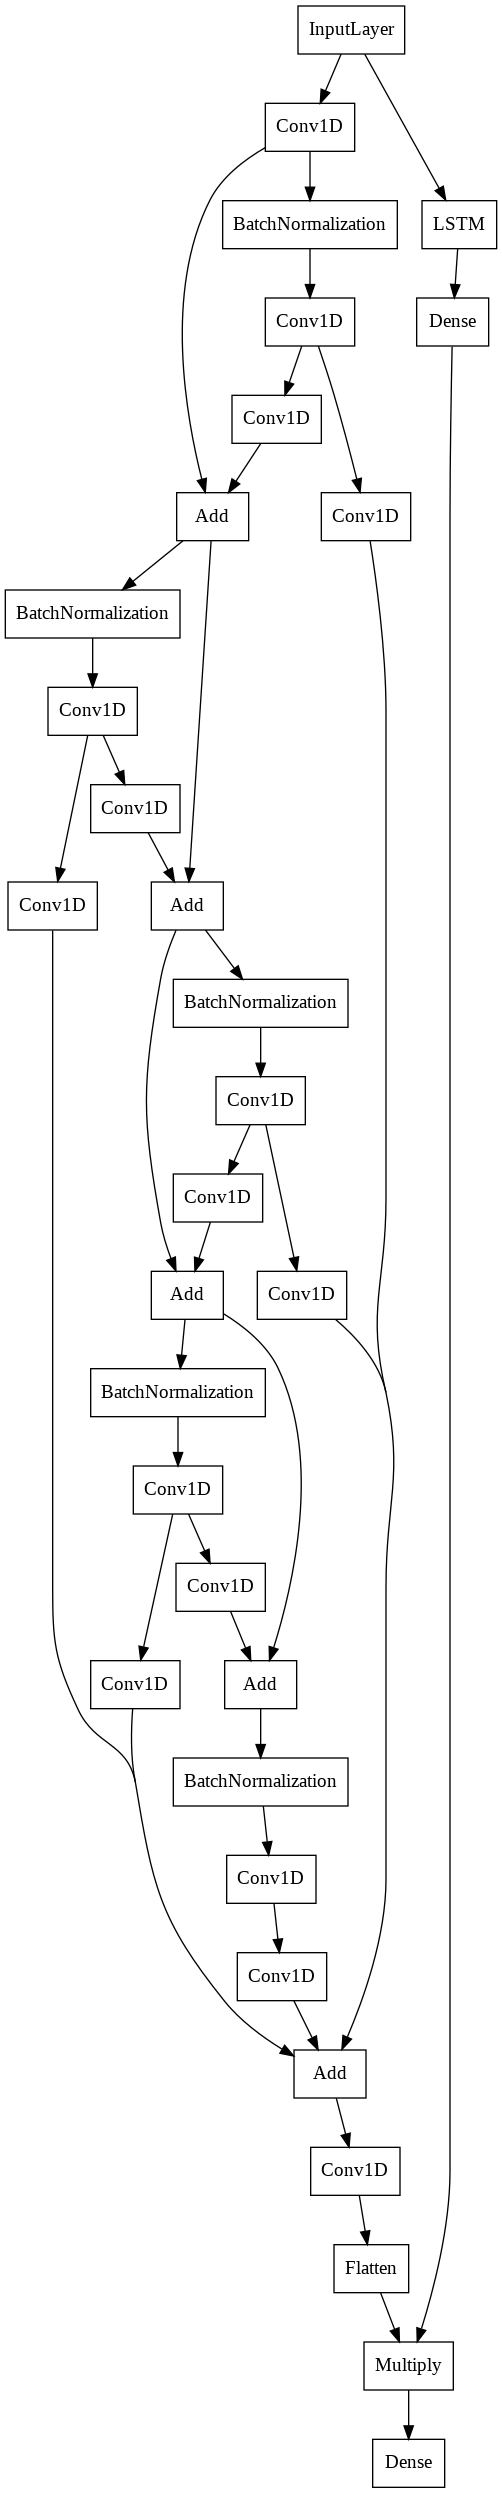

In [9]:
model.summary()
tf.keras.utils.plot_model(model, show_layer_names=False)

#### Callback pour un early stopping
Le modèle est entraîné sur 5000 époques initialement mais l'entraînement prend fin si il n'y a pas d'amélioration sur la RMSE de validation après 200 époques.
Le meilleur modèle est restauré.

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                            patience=200,
                                            verbose=1,
                                            restore_best_weights=True)

In [ ]:
history = model.fit(x=X_train, 
          y=Y_train,
          batch_size=4096,
          epochs=5000,
          validation_data=[X_val, Y_val],
          callbacks=[callback])

Le modèle a nécessité 1841 époques pour converger, il obtient une Train_RMSE de 3175.0115 et une Val_RMSE de 2574.7397

#### Prédiction et RMSE

In [14]:
pred = model.predict(X_test)

rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(Y_test, pred)
print("RMSE : ", rmse.result().numpy())

499/499 [==============================] - 2s 4ms/step
RMSE :  2270.8503


#### Visualisation des trois premières semaines de 2022
Il manque les 90 premières observations dû au preprocessing.

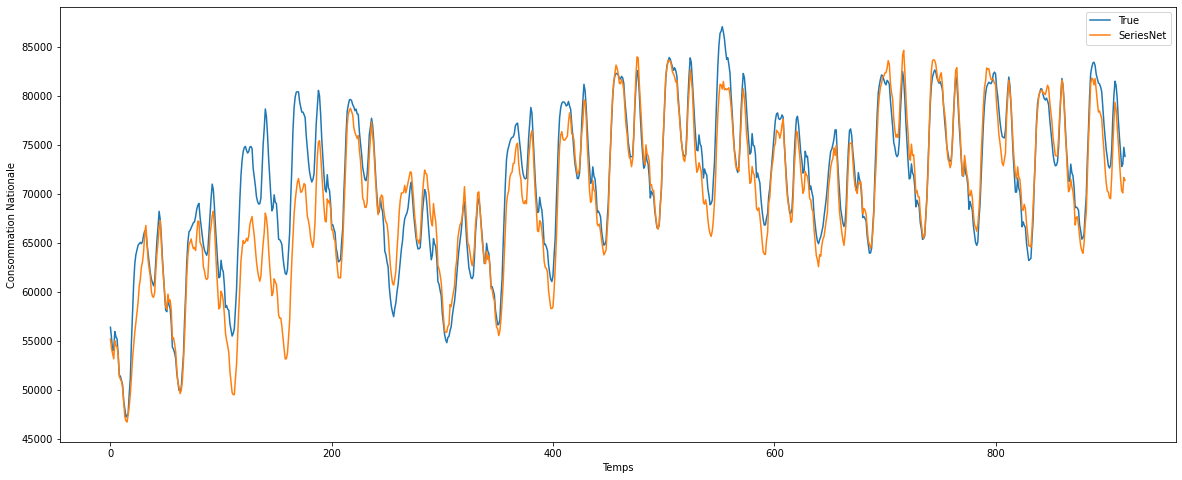

In [15]:
plt.figure(figsize=(20,8))
plt.plot(Y_test.reset_index()["Conso"][0:918])
plt.plot(pred[0:918])
plt.legend(["True", "SeriesNet"])
plt.xlabel("Temps")
plt.ylabel("Consommation Nationale")
plt.show()